<a href="https://colab.research.google.com/github/pda-sedano/quantum_computing_research/blob/main/quantum_teleportation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Restarts kernel
# From comment on https://stackoverflow.com/a/64356932/7233512
# import os
# os._exit(00)

In [2]:
# Installs missing packages
# !pip install qiskit
# !pip install qiskit_aer
# !pip install pylatexenc

In [3]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.quantum_info import partial_trace, Statevector
from qiskit.visualization import plot_histogram

In [4]:
simulator = Aer.get_backend('statevector_simulator')
qc = QuantumCircuit(3, 3)
qc.initialize(np.random.rand(2) + [0, 1j * np.random.rand()], 0, normalize=True) # State to be teleported

print('Initial state:')
print(Statevector(qc))

# Alice generates entangled pair
qc.h(1)
qc.cx(1, 2)


print('After qubits 1 and 2 entangled:')
print(Statevector(qc)) # Seems good up to here

# |
# |
# (Alice sends off qubit 2 to Bob)
# |
# |
# V
# Alice prepares to measure qubits 0 and 1 in the Bell basis
qc.cx(0, 1)
qc.h(0)

print('Once Bell basis converted to computational basis:')
print(Statevector(qc)) # Looks good up to here

qc.measure([0, 1], [0, 1])
qc_compiled = transpile(qc, simulator)
job = simulator.run(qc_compiled, shots=1)

# Alice sends measurement result to Bob
result = job.result()
counts = result.get_counts(qc_compiled)
print(counts)
plot_histogram(counts)
state_vector = result.get_statevector()
print('After Bell basis measurement:')
print(state_vector) # Looks good up to here

# Extract last qubit from state vector
# Technique from this answer: https://quantumcomputing.stackexchange.com/a/16093
density_matrix = partial_trace(state_vector, [0, 1])
print(density_matrix)
print('State vector of qubit 2 after Bell basis measurement:')
bobs_qubit = density_matrix.to_statevector()
print(bobs_qubit)

# Bob applies proper Pauli matrices
bobs_circuit = QuantumCircuit(1)
proper_gate_according_to_measurement = {'00': 'I', '01': 'Z', '10': 'X', '11': 'XZ'}
gate = proper_gate_according_to_measurement[list(counts.keys())[0][1:]]
print(gate)

if gate == 'XZ':
    bobs_circuit.pauli('Z', [0])
    bobs_circuit.pauli('X', [0])
elif gate != 'I':
    bobs_circuit.pauli(gate, [0])

bobs_qubit = bobs_qubit.evolve(bobs_circuit)
bobs_qubit *= np.abs(bobs_qubit[0]) / bobs_qubit[0]
print(bobs_qubit)

Initial state:
Statevector([0.66867793+0.j        , 0.72067403+0.18302671j,
             0.        +0.j        , 0.        +0.j        ,
             0.        +0.j        , 0.        +0.j        ,
             0.        +0.j        , 0.        +0.j        ],
            dims=(2, 2, 2))
After qubits 1 and 2 entangled:
Statevector([0.4728267 +0.j        , 0.50959349+0.12941943j,
             0.        +0.j        , 0.        +0.j        ,
             0.        +0.j        , 0.        +0.j        ,
             0.4728267 +0.j        , 0.50959349+0.12941943j],
            dims=(2, 2, 2))
Once Bell basis converted to computational basis:
Statevector([ 0.33433896+0.j        ,  0.33433896+0.j        ,
              0.36033701+0.09151335j, -0.36033701-0.09151335j,
              0.36033701+0.09151335j, -0.36033701-0.09151335j,
              0.33433896+0.j        ,  0.33433896+0.j        ],
            dims=(2, 2, 2))
{'011': 1}
After Bell basis measurement:
Statevector([ 0.        +0.j       

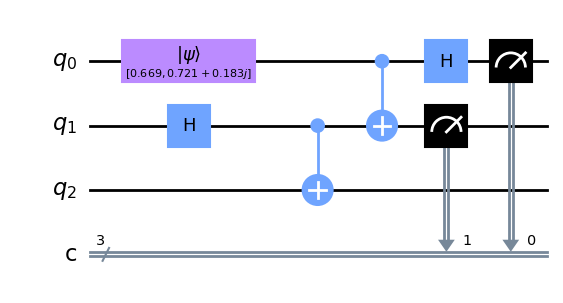

In [5]:
qc.draw('mpl')

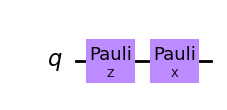

In [6]:
bobs_circuit.draw('mpl')